# Introduction #

First of all we import numpy and matplotlib under the names np and plt,
respectively, as this is very common in the Python scientific computing
community and a good programming habit.

In [5]:
%matplotlib inline

import math
import scipy
import numpy             as np
import pandas            as pd
import scipy.stats       as ss
import matplotlib
import pylab

from pylab import *
from matplotlib import pyplot as pl

# local module
import ACF_utils
from ACF_utils.Trees import binomial_tree

In [6]:
#Black and Scholes
def d1(S0, K, r, delta, sigma, T):
    return (np.log(S0 / K) + (r - delta + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, delta, sigma, T):
    return (np.log(S0 / K) + (r - delta - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(type, S0, K, r, delta, sigma, T):
    # for the cumulative normal distribution function we use norm.cdf from
    # the library scipy.stats
    if type=="C":
        return S0 * np.exp(- delta * T) * ss.norm.cdf(d1(S0, K, r, delta, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, delta, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, delta, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, delta, sigma, T))


Let's start with a quick review of the problem of early exercise. First of all take a look at a very well known plot, the graph of the european option price from the Black and Scholes model...

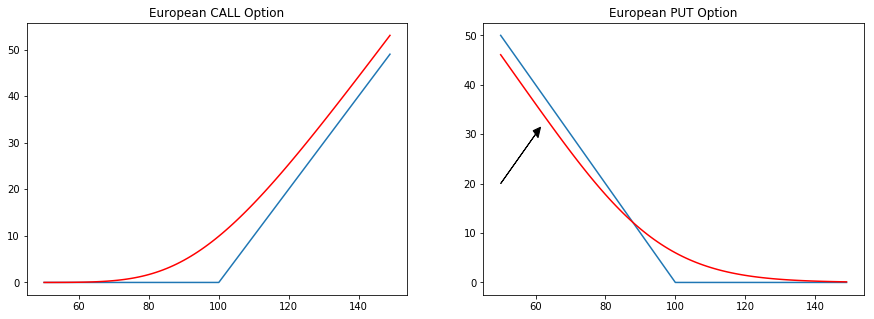

In [7]:
K     = 100.0   # strike price
T     =   1     # time-to-maturity
r     =   0.04  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

S      = np.arange(50, 150, 1.0)
C      = BlackScholes('C', S, K, r, delta, sigma, T)
P      = BlackScholes('P', S, K, r, delta, sigma, T)
payC   = np.maximum(S-K,0)
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European CALL Option')
plt.plot(S,payC)
plt.plot(S,C,color='r')

plt.subplot(122)
plt.title('European PUT Option')
plt.arrow(50,20,10,10,head_width=2, head_length=2, fc='k', ec='k')
plt.plot(S,payP)
plt.plot(S,P, color='r')


This figure show that before expiry there is a large range of asset values $S$ for which the value of a European Put Option is less than its intrinsic value (the payoff function). Suppose that $S$ lies in this range, so that $P(S,T) < max(K-S,0)$, and consider the effect of exercising the option. There is an obvious arbitrage opportunity: **we can buy the asset in the market for $S$ and, at the same time we buy the option for $P$**.If we immediately exercise the option by selling the asset for K we thereby make a risk-free profit because $K-S > P \Rightarrow K-S-P > 0$. Of course such an opportunity would not last long before the value of the option was pushed up by the demand of arbitrages. We conclude that when early exercise is permitted we must impose the constraint

$$
P(S,t) \ge max(K-S,0)
$$

American and European Put Options must therefore have different values.

A second example of an American option whose differes from that of its European equivalent is a call option on a dividend-paying asset. 

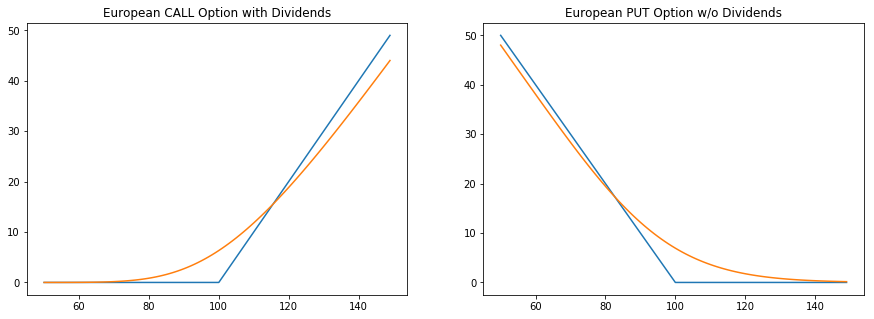

In [8]:
delta  =   0.05  # dividend yield
r      =   0.02

S      = np.arange(50, 150, 1.0)
C      = BlackScholes('C', S, K, r, delta, sigma, T)
P      = BlackScholes('P', S, K, r, 0.0, sigma, T)
payC   = np.maximum(S-K,0)
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European CALL Option with Dividends')
plt.plot(S,payC)
plt.plot(S,C)

plt.subplot(122)
plt.title('European PUT Option w/o Dividends')
plt.plot(S,payP)
plt.plot(S,P)


As we can see an arbitrage argument as above can be used to show that the American version of this option must also be more valuable than the European version since it must satisfy the constraint

$$
C(S,t) \ge max(S-K,0)
$$



## The Problem of Early Exercise ##

### Optimal Stopping Time ###

The valuation of early-exercisable options, or American style options, is a task of major importance in derivatives pricing because these types of instruments are found in all major financial markets including equity, commodity, foreign exchange, credit and convertible. Even though some authors presented analytical approximations for certain early-exercisable options, exact closed-form solutions are in general not existent for these instruments. 

Let's formulate exactly the problem of the early exercise in order to understand what is the main difficulty in finding the solution of the evaluation problem.

American type derivative securities contain implicit or explicit options which **can be exercised before expiration date if desired**.

Consider an American option written on a stock. The option can be exercised at any time between the present date $t=0$ and time to maturity $t=T$. **The holder will exercise this option if he thinks that it is better to do so, rather than waiting until expiration**. The right of early exercise may have some additional value and pricing methods for American style securities must take this into account.

Let $\tau \in [0,T]$ represents the early exercise date. Given the information set at time $t$, $I_t$ , we will be able to tell whether the option has already been exercised or not. The problem is that with American type securities $\tau$ is in general random. 

The option price may be described by a generic function $F(S_t, t)$. In the most simple framework, the underlying stock price is assumed to behaves in continuous time as a geometric Brownian motion

\begin{equation}
dS = \mu S \> dt + \sigma S \> dz
\end{equation}

and, as we already known, the price of the derivative can be expressed using the risk neutral $Q$, **but this time the option holder does not have to wait until expiration $T$ to exercise the option. He will exercise the option as soon as it is more profitable to do so**. If the option is exercised at a generic time $\tau$ its value at $t$ would be

\begin{equation}
F(S_t, t) = E^Q_t \left[ e^{-r(\tau-t)} max\left(S_\tau - K,0 \right) \right]
\end{equation}

Therefore the pricing problem at time $t=0$ becomes the calculation of

\begin{equation}
F(S_0, 0) = \sup\limits_{\tau \in [0, T]} 
\left\{
E^Q_0 \left[ e^{-r\tau} max\left(S_\tau - K,0 \right) \right]
\right\}
\end{equation}

This supremum is achieved by an optimal stopping time $\tau^\star$ that has the form

\begin{equation}
\tau^\star = \inf \left\{ t \ge 0: S_t \ge b^\star_t \right\}
\end{equation}

for some optimal exercise boundary $b^\star$.

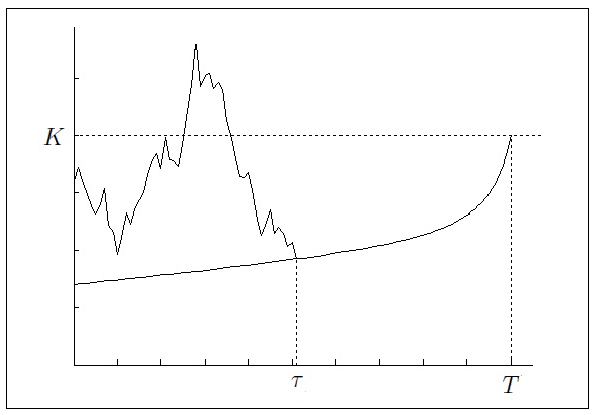
**Figure 1**: *The optimal exercise boundary and a stock price trajectory and its corresponding $\tau^\star$, the ﬁrst time it goes below $b^\star$*


**Since the asset price at which the early exercise is optimal isn’t known in advance it has to be found as part of the solution problem**.

For this reason an analytic solution to the problem does not exist except for very special cases. Thus the general practice is to implement numerical procedures to generate accurate estimates of the option price

### Stopping Rules ###


Any *stopping time* $\tau$ results in a value

\begin{equation}
V_0^\tau \left( S_0 \right) = E \left[ h_\tau \left( S_\tau \right) \right]
\end{equation}

where $h_t \left( S_t \right)$ is the option payoff.  On the other hand, if we assign any values $\hat V_i (s)$ to the option on each of the time states (with the final condition that $\hat V_T = h_T(S_T)$), we can make a stopping rule as

\begin{equation}
\tau^\star = \min \left\{ i \in \{1,\dots,n\}: 
h_i(S_i) \ge \hat V_i(S_i) \right\}
\end{equation}

**In other words we exercise the option when the payoﬀ from exercising, $h_i(S_i)$ is higher than what we expect to gain if we continue (continuation values)**. The continuation values are the values of holding the option rather than exercising it. The problem is, as before, that in general we do not known in advance what is the continuation values. As we have already said this is, in general, part of the problem we are dealing with. 

### Strengths and weaknesses of different computational methods ###

The primary methods for pricing such derivatives are binomial trees, finite difference and LS-Montecarlo methods. 

The tree method discretizes the solution space although the discretization is chosen to represent the distribution of the underlying stock price process, instead of the entire solution space. 

The finite difference method estimates the solution of a partial differential equation (PDE) by discretizing the solution space into a grid and then solving the PDE by recursion. 

The **shortcoming** is that **these techniques become computationally prohibitive when they are generalized to handle multiple dimensions**, with computation time typically increasing exponentially with the number of state variables.

Usually both these procedures start from the maturity date and then go **backward** toward time zero. In doing this they construct a hedging portfolio that perfectly replicates the payoffs in the future and finally set the option price equal to the value of the hedging portfolio at time zero. Working backwards in time starting from the expiration date, the optimal exercise strategy and the price of the options can be easily estimated, so a **strength of tree and finite difference methods is that they can handle easily the early exercise feature of american products**.

The use of simulation methods in security pricing may offer a number of decisive advantages. First of all **the convergence rate of the Monte Carlo approach is independent of the number of state variables** which makes the method computationally appealing for solving high-dimensional problems. Moreover the method is flexible with respect to the evolution of the state variables offering the opportunity to price derivative securities with more complex process dynamics. At the end path dependency features can easily be incorporated in a Monte Carlo pricing framework. On the other hand, **the major drawback of simulation procedures is the difficulty in dealing with the early exercise feature of American options**. 

In particular, standard simulation procedures are **forward** algorithms, that is, the trajectories of the state variables are simulated forward in time. Then, given a pre-specified exercise policy, a path price is determined for each trajectory. The average of path prices gives an unbiased estimate of the derivative security price.  

### Forward Algorithm ###

The approach is easy and intuitive: We simulate $n$ random trajectories using time discretization. Then we compute the value of the option in each trajectory and get an average on all of them, leading to an estimated value of the European option.

In [9]:
#np.random.seed(150000)
# Model Parameters
S0    =  70.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.01  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

# Simulation Parameters
b = 10000    # number of paths
M = 100      # number of points for each path
dt = float(T) / float(M)
df = math.exp(-r * dt)
#
# Random numbers generations. We use the function 'randn' which returns 
# a sample (or samples) from the "standard normal" distribution.
# If positive, int_like or int-convertible arguments are provided,
# 'randn' generates an array of shape (d0, d1, ..., dn), filled
# with random floats sampled from a univariate "normal" (Gaussian)
# distribution of mean 0 and variance 1
#
z1  = np.random.randn(M + 1, b)
#
# Stock Price Paths. The function 'cumsum' returns the cumulative sum 
# of the elements along a given axis, in this case we want to sum along
# the time axis (axis=0). Note that since z1 is a 2D-array also S is
# a 2D-array
#
S     = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt 
       + sigma * math.sqrt(dt) * z1, axis=0))
S[0]  = S0

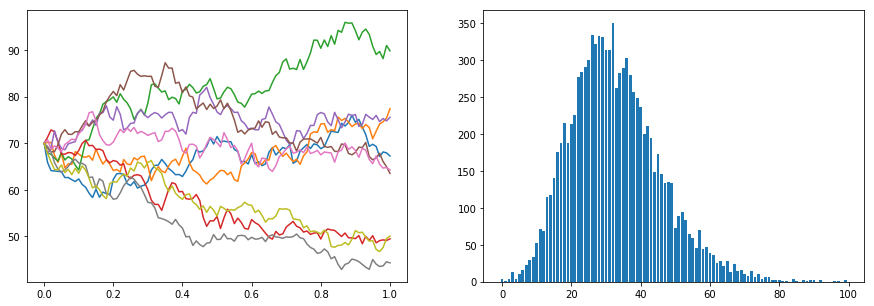

In [10]:
# plotting the first n paths
t = np.linspace(0, T, M+1)
paths = S[:,0:9]
#
# plotting expiry price distribution. Note that the S matrix is build 
# with the first index running on the time slice and the second index
# running on the number of simulated path. Remember that Python programming 
# language supports negative indexing of arrays, something which is not 
# available in arrays in most other programming languages. This means that 
# the index value of -1 gives the last element, and -2 gives the second 
# last element of an array. The negative indexing starts from where the 
# array ends. So in this case we are selecting all the simulated value 
# (second index = ':') of the last simulated time (first index = '-1').
#
expiry = S[-1,:]
hist = np.histogram(expiry, 100)
index = np.arange(100)

pl.figure(figsize=(15,5))
pl.subplot(121)

strike = np.array([K for n in range(0,M+1)])
#pl.plot(t, strike, color='r', dashes=[6,2], linewidth=3.0)
pl.plot(t, paths)

pl.subplot(122)
pl.bar(index, hist[0])

pl.show()

By contrast, as we have seen, pricing methods for American style derivatives are generally backward algorithms. That is to say, the optimal exercise strategy at maturity is determined and proceeding backward in time dynamic programming determines the optimal exercise strategy and the corresponding price at previous dates. 

**The problem of using simulation methods to price American options stems from the difficulty in applying forward-based procedures to problems that necessitate a backward procedure to be solved**.

All the numerical methods we are dealing with, use time discretization for pricing American put options. So in fact they consider that exercising the option is possible only on a ﬁnite number of times. These kind of options are called Bermudan. So we actually are discussing methods for Bermudan put options. Of course we can recover the case of an American Option choosing time intervals small enough.

## Binomial Tree for Option Pricing ##

### What is a binomial tree ###

The binomial pricing method is a simple and computationally fast method for pricing
vanilla options. 

With this method, you create **a tree of possible price outcomes of the underlying asset**. To do this you start with the current spot price of the underlying asset. From this, you create two branches, one with the expected price in the next period in an upstate and the other for the expected price in a downstate. These states are calculated by dividing the life of the option into a large numer of intervals $n$ of equal length $\Delta t$. 

At each period, the stock may move from the initial value $S$ to either up ($Su$) with probability p or down ($Sd$) with probability $q=1-p$. The interest rate is constant and is denoted by $r$. From each of these branches you will create two more branches by the same process. This process is repeated until the options expiry is reached, creating a price tree.

Let's start considering only one period to expiration, an hypothetical call option written on the asset will have at expiration the payoffs $c_u = \max[0, S_0u-K]$ if the stock price goes to $S_0u$ and $c_d= \max[0, S_0d-K]$ if the stocks decreases to $S_0d$.

If a portfolio can be constructed with a long position of $\Delta$ shares of the stock and a short position in the option, the value of our portfolio in the two states will be:

$$\Delta S_0u - c_u$$ 
$$\Delta S_0d - c_d$$

It is easy to find that if we choose $\Delta$ as 

\begin{equation}
  \Delta = \frac{C_u - C_d}{(u-d)S_0} \sim \frac{\partial C}{\partial S}
\end{equation}

our portfolio will have the same value in both states so it will be a *risk free* portfolio.

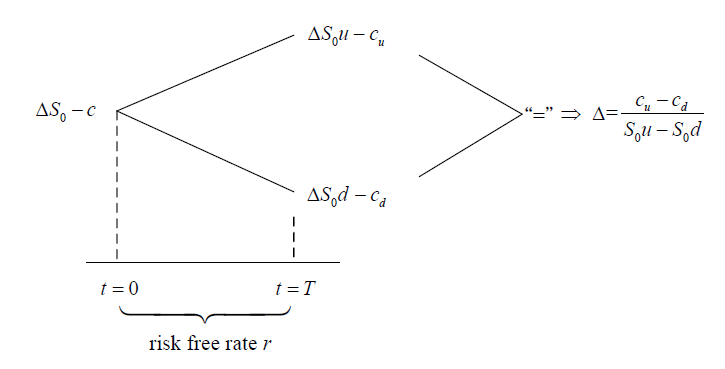

To preclude the existence of arbitrage opportunities in the market the yield of our portfolio must be the risk free rate, so considering a unit interval we have

$$
P_T = e^{rT}P_0
$$

\begin{align}
&\frac{P_T}{P_0} = \frac{S_0 \Delta \cdot  u -c_u}{S_0 \Delta  - C} \> = e^{rT} \Rightarrow \notag\\
\Rightarrow C &= \frac{S_0 \Delta \cdot e^{rT} + c_u - u S_0 \Delta }{e^{rT}} \notag\\\
              &= \frac{S_0\Delta\cdot  (e^{rT}-u) + c_u}{e^{rT}}
\end{align}

and, using the value of $\Delta$ 

\begin{align}
C &= \frac{\frac{c_u-c_d}{u-d}(e^{rT}-u)+c_u}{e^{rT}}  \notag\\
  &= \frac{c_ue^{rT}-c_uu-c_de^{rT}+c_du+c_uu-c_ud}{e^{rT}(u-d}  \notag\\
  &= e^{-rT} \frac{c_u(e^{rT}-d) + c_d(u-e^{rT})}{(u-d)} \notag\\
  &= e^{-rT} \left[ c_u \frac{e^{rT}-d}{u-d} + c_d \frac{u-e^{rT}}{u-d} \right] \notag\\
  &= e^{-rT}\Bigl[ p\cdot c_u + (1-p) \cdot c_d \Bigr] 
\end{align}

where

\begin{equation}
  p \equiv \frac{e^{rT}-d}{u-d} \quad \quad 1-p \equiv \frac{u-e^{rT}}{u-d}
\end{equation}

$p$ if we assume $d \le r \le d$, $p$ is always greater than zero and less than one showing the basic properties of a probability measure.

### The Cox, Ross and Rubinstein Tree ###

With respect to the definition of $p$, $u$ and $d$ an important assumption about the behavior of the stochastic process of the underlying stock has to be done. In the following we'll follow the framework set up by Cox, Ross and Rubinstein. 

Let's assume that the stochastic process is continuous as $n \rightarrow \infty$. The parameters $p$, $u$ and $d$ must be chosen in a way to determine the right values of the stock expected return and variance at the end of each interval $\Delta t$. **Given the assumption of risk neutrality the one period expected return of the stock is equal to the risk free rate**

$$r \Delta t$$ 

and the expected future stock price is

\begin{equation}
        Se^{r\Delta t} =pSu + (1-p)Sd \Rightarrow  E_\pi \left[r\Delta t \right] =pu + (1-p)d
\end{equation}

and the variance of this return is given by

\begin{equation}
        \mathit{Var}\>(r \Delta t) = 
        E_\pi [(r\Delta t)^2] - [E_\pi(r \Delta t)]^2 = [pu^2 +(1-p)d^2] - [pu + (1-p)d]^2
\end{equation}

The Cox, Ross and Rubinstein binomial tree model assume that in the limit $n \rightarrow \infty$, the discrete process must converge to the ordinary Black and Scholes framework with a geometric brownian motion for the underlying stock price. So the idea is to find values for $u$ and $d$ in order to have

$$\mathit{Var}\>(r \Delta t) = \sigma^2 \Delta t$$

We need an additional assumption in order to obtain a tree that recombines, so that the effect of a down movement followed by an up movement is the same as the effect of an up movement, followed by a down movement.

\begin{equation}
        u=\frac{1}{d}
\end{equation}

With a bit of trivial algebra we find

\begin{align}
\mathit{Var}\>(r \Delta t) & = p u^2 +(1-p)d^2 - p^2u^2-(1-p)^2d^2 - 2p(1-p)ud \notag\\
&= pu^2 (1-p) + p(1-p)d^2 - 2p (1-p)ud \notag\\
&= p(1-p)(u^2+d^2-2ud) \notag\\
&= p(1-p)(u-d)^2 \notag\\
&= \frac{e^{r\Delta t}-d}{u-d} \Bigl[\frac{u-e^{r\Delta t}}{u-d}\Bigr] (u-d)^2 \notag\\
&= (e^{r\Delta t} -d)(u-e^{r\Delta t})  \notag\\
&= e^{r\Delta t}(u+d) -ud-e^{2r\Delta t}
\end{align}

from the last row, keeping the lower order terms we have

\begin{align}
\mathit{Var}\>(r \Delta t) &=
    e^{r\Delta t}(u+d) -ud-e^{2r\Delta t} \notag\\
    &\sim (1+r\Delta t)(u+d)-1-1-2r\Delta t \notag\\
    &= (1+r\Delta t)(u+d-2)
\end{align}

If we choose

\begin{equation}
u = e^{\sigma\sqrt{\Delta t}} , \quad \quad d = \frac{1}{u} = e^{-\sigma\sqrt{\Delta t}}
\end{equation}

up to the first order in $\Delta t$ we have

\begin{equation}
u \sim 1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t , \quad \quad d \sim 1-\sigma\sqrt{\Delta t}+\frac{1}{2}\sigma^2 \Delta t
\end{equation}

and finally

\begin{align}
\mathit{Var}\>(r \Delta t) &= 
(1+r\Delta t)(u+d-2) \notag\\
&\sim (1+r\Delta t)\Bigl(1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t
+1 - \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t -2 \Bigr) \notag\\
&=(1+r\Delta t)\Bigl(\sigma^2 \Delta t \Bigr) \notag\\
&\sim \sigma^2 \Delta t + O\left({(\Delta t)^2} \right)
\end{align}

Ok, now the time has come to translate all this theory into python code. Let's start...

### Option Pricing with Binomial Tree in Python ###

First of all, we define some functions for the analytical pricing of an european option according to the Black and Scholes model. The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

\begin{aligned}
C(S_{t},t) &=N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)} \\
d_{1} &={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\
d_{2} &= d_{1}-\sigma {\sqrt {T-t}}
\end{aligned}

The price of a corresponding put option based on put–call parity is:

\begin{aligned}
P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\
&=N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}
\end{aligned}

For both:

- $N(\cdot )$ is the cumulative distribution function of the standard normal distribution
- $T-t$ is the time to maturity (expressed in years)
- $S_{t}$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
- $\sigma$  is the volatility of returns of the underlying asset


**European Options**

In [11]:
def binomial_model_european(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial levels
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    #
    # u and d values are chosen according to the CRR model
    #
    u = exp(sigma*sqrt(delta_t))
    d = 1 / u
    p = (exp(r*delta_t)- d) / (u - d)
    q = 1 - p
    #
    # make stock price tree
    # 
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)
    #
    # Initialize option matrix 
    #
    option = np.zeros([N + 1, N + 1])
    # 
    # Generate option prices recursively
    #
    #
    # We start from the maturity (the binomial tree is a backward 
    # in time algorithm remember?). At maturity we know the value 
    # of the option in all states, it is simply the payoff. In this
    # case the payoff is that of a put option.
    #
    if opt_type == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
    return [stock, option]

calculating example option price:

In [12]:
S0    =  90.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.05  # short rate
sigma =   0.30  # volatility
delta =   0.0   # dividend yield

N     =   10
result = binomial_model_european(N, S0, sigma, r, K, T) 

In [13]:
print('Option price (binomial tree): ', round(result[1][0][0],3))

('Option price (binomial tree): ', 14.021)


In [14]:
opt_bs = BlackScholes('P', S0, K, r, 0.0, sigma, T)
print('Option price (analytic)     : ', round(opt_bs,3))

('Option price (analytic)     : ', 13.784)


The "topology" of the tree is described in the following picture

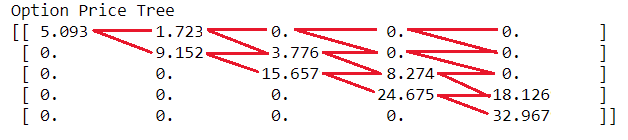

In [15]:
if N <= 5:    
    print('Option Price Tree')
    print(result[1])

In [16]:
if N <= 5:
    print('Stock Tree')
    print(result[0])

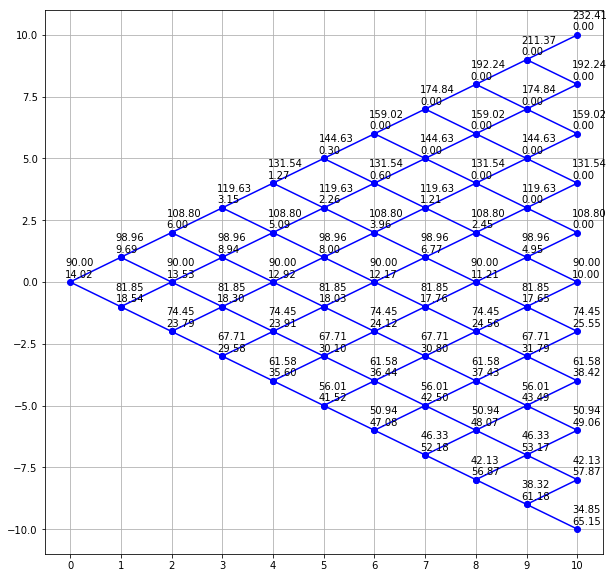

In [17]:
if N <= 20:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)        

### Convergence Rate ###

When using binomial trees, errors may occur if only a few periods are used. This is
because a binomial tree will only produce one more leaf node (or potential outcome) than the
number of periods used, when infinite outcomes are actually possible. By increasing the number
of periods, we create more possible outcomes that are distributed more continuously.

In [18]:
nn         = range(1,100)
opt_bs     = BlackScholes('P', S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = [binomial_model_european(k, S0, sigma, r, K, T)[1][0][0] for k in nn]

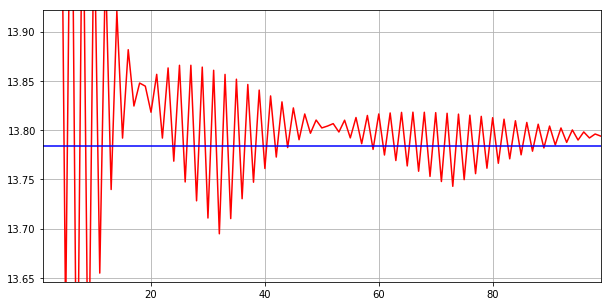

In [19]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()


### American Options ###

The method used to evaluate an American style derivative is very similar to that for the European option except that it is necessary to incorporate the early exercise feature. In the case of American options the value of the option at any node in the binomial tree is the greater between the value calculated by backward induction (the **continuation value**) and the payoff from early exercise. Specifically at time $t$ and node $i$ 

\begin{equation}
c_t^i = max \left[ 
max \left(K - S_t^i,o \right),  
e^{-rt}\left(p c_{t+1}^u + (1-p)c^d_{t+1}\right) 
\right]
\end{equation}

This is repeated until you return to the final node at the present time. This final node is the price of your options contract.

In [20]:
def binomial_model_american(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial iterations
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    u           = exp(sigma*sqrt(delta_t))
    d           = 1 / u
    p           = (exp(r*delta_t)- d) / (u - d)
    q           = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    if opt_type  == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
            #
            # dealing with early exercise
            #
            if opt_type == 'put':
                exercise     = np.maximum(0, K - stock[j, i])  
            else:
                exercise     = np.maximum(0, stock[j, i] - K)
                
            option[j, i] = np.maximum(exercise, option[j, i])

    return [stock, option]

In [21]:
result = binomial_model_american(N, S0, sigma, r, K, T, 'put')

print('Option price (binomial tree): ', result[1][0][0])

opt_bs = BlackScholes('P', S0, K, r, 0, sigma, T)
print('Option price (analytic)     : ', opt_bs)

('Option price (binomial tree): ', 14.88009457061864)
('Option price (analytic)     : ', 13.783997639927065)


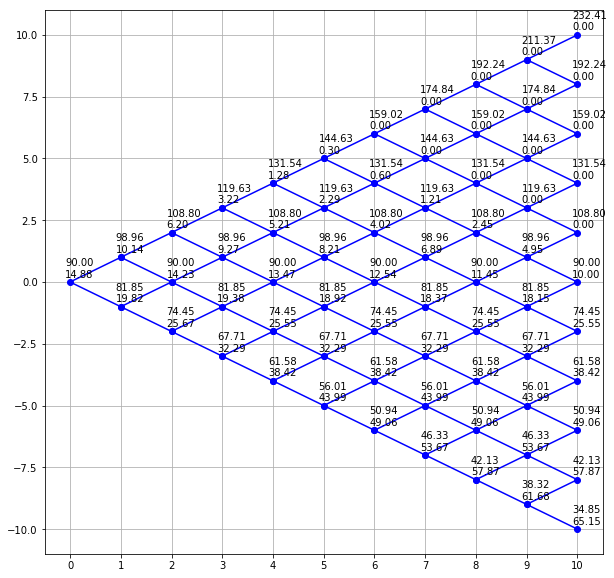

In [22]:
if N <= 20:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)     

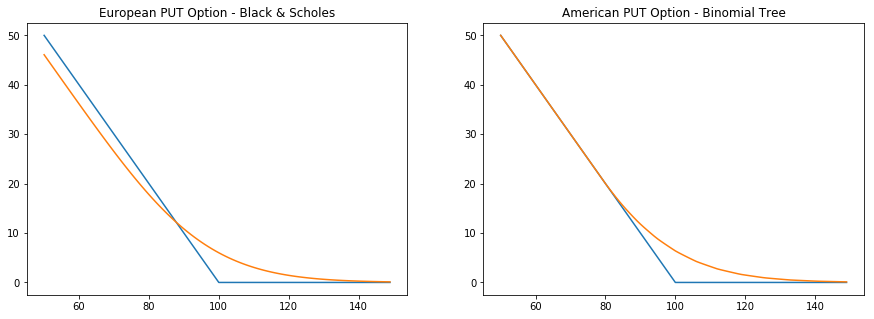

In [23]:
K     = 100.0   # strike price
T     =   1     # time-to-maturity
r     =   0.04  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

S      = np.arange(50, 150, 1.0)
PE     = BlackScholes('P', S, K, r, delta, sigma, T)
PA     = [binomial_model_american(50, s, sigma, r, K, T)[1][0][0] for s in S]
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European PUT Option - Black & Scholes')
plt.plot(S,payP)
plt.plot(S,PE)

plt.subplot(122)
plt.title('American PUT Option - Binomial Tree')
plt.plot(S,payP)
plt.plot(S,PA)


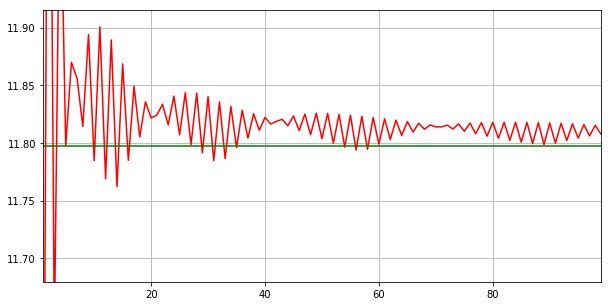

In [24]:
nn     = range(1,100)
prices = [binomial_model_american(k, S0, sigma, r, K, T)[1][0][0] for k in nn]

opt_bs = np.array([opt_bs for k in nn])
opt_fd = finite_difference_explicit('put', S0, K, sigma, T, True)
opt_fd = np.array([opt_fd for n in nn])

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_fd[0], 1.01 * opt_fd[0])
pl.plot(nn, opt_bs, color='b')
pl.plot(nn, prices, color='r')
pl.plot(nn, opt_fd, color='g')
pl.grid()
pl.show()

# Finite Difference #

## Introduction ##

Finite difference methods for option pricing are numerical methods used in mathematical finance for the valuation of options. Finite difference methods were first applied to option pricing by Eduardo Schwartz in 1977.

In general, finite difference methods are used to price options by approximating the (continuous-time) differential equation that describes how an option price evolves over time by a set of (discrete-time) difference equations obtained by approximation of the partial derivative 

\begin{equation}
        \frac{\partial C}{\partial S} \Rightarrow \frac{\Delta C}{\Delta S}
\end{equation}

The discrete difference equations may then be solved iteratively to calculate a price for the option. The approach arises since the evolution of the option value can be modelled via a partial differential equation (PDE), as a function of (at least) time and price of underlying; see for example Black–Scholes PDE. Once in this form, a finite difference model can be derived, and the valuation obtained.

The stock-time (or S-t) plane is discretized into a grid of nodes. The examined time
points are $0,\Delta t, 2\Delta t, \dots, K\Delta t$, and the examined stock prices are 
$0,\Delta S, 2\Delta S,\dots, I\Delta S$.
The numerical solution of $f$ means to find the values for all $U_{i,k}$ , where $i$ and $k$ are the
indexes for the Stock price and the Time, respectively:

$$
    S = i \Delta S, \quad \quad t = T - k \Delta T
$$

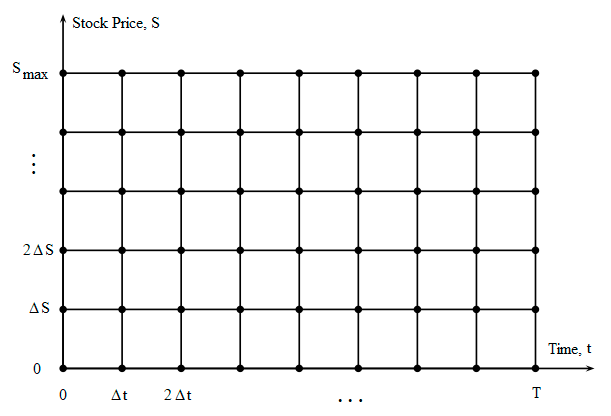
 
where $0 \le i \le I$ and $0 \le k \le K$. This means that we will be solving for the asset value going from zero up to the asset value $I\Delta S$. Remembering that the Black and Scholes equation is to be solved for $0 \le S \le \infty$, then $I \Delta S$ is our approximation to infinity. Please note that we are going backward in time starting from the expiration and going back to time 0. 

I will write the option value at each of these grid point as 

$$
U_{i,k} = U(i\Delta S, T - k \Delta t)
$$

### Discrete Approximation for Derivatives ###

**Forward Approximation (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x+h)-f(x)}{h}+O(h)
\end{equation}

**Backward Approximation  (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x)-f(x-h)}{h}+O(h)
\end{equation}

**Central Approximation  (1st order)**

\begin{equation}
    f^\prime (x) = \frac{f(x+h)-f(x-h)}{2h}+O(h^2)
\end{equation}


From Taylor's series we can obtain a valid approximation up to third order terms

\begin{align}
    &f(x+h) = f(x) + f^\prime(x) h + \frac{1}{2} f'' (x) h^2 + O(x^3) \notag\\
    &f(x-h) = f(x) - f^\prime(x) h + \frac{1}{2} f'' (x) h^2 + O(x^3) \notag\\
\end{align}

summing up we obtain

\begin{align}
    f''(x) =\frac{f(x+h)-2f(x) + f(x-h)}{h^2} + O(x^3)
\end{align}


### Final Conditions and Payoff ###

We know that at expiry the option value is just the payoff function. This means that we don't have to solve anything for time T. At expiry we have 

$$
U(S,t) = \text{Payoff}(S) \Rightarrow U_{i,0} = \text{Payoff}(i\Delta S)
$$

The right-hand side is a known function. For example, if we are pricing a call option we put

$$
U_{i,0} =  \max(i\Delta S - K, 0)
$$

This final condition will get our finite-difference scheme started. It will be just like working down the tree in the binomial model. 

### Boundary Condition ###

When we come to solving a PDE numerically we must specify the solution value at the extremes of the region. In our specific pricing problem this means that we have to prescribe the option value at $S=0$ and $S=I \Delta S$. What we specify will depend on the type of option we are solving. Let's see some examples.

**Call Option** - At $S=0$ we have always

\begin{equation}\label{eqn:boundary_condition_1}
U_{0,k}=0
\end{equation}

For large value of $S$ the call value approximate $S-Ke^{-r(T-t)}$ so we can set 

\begin{equation}\label{eqn:boundary_condition_2}
U_{I,k} = I \Delta S - Ke^{-rk \Delta t}
\end{equation}

**Put Option** - For a put option we have the condition at $S=0$ that $P=Ke^{-r(T-t)}$, this becomes   

\begin{equation}\label{eqn:boundary_condition_3}
U_{0,k} = Ke^{-rk \Delta t}
\end{equation}

The put option become worthless for large $S$ so

\begin{equation}\label{eqn:boundary_condition_4}
U_{I,k}=0
\end{equation}

When the option has a payoff that is most linear in the underlying for large value of $S$ then you can use the upper boundary condition

$$
\frac{\partial^2 U(S,t)}{\partial S^2} \rightarrow 0 \quad \text{as} \quad S \rightarrow \infty
$$

The finite-difference representation is

\begin{equation}\label{eqn:boundary_condition_5}
U_{I,k} - 2U_{I-1,k} + U_{I-2,k} = 0 \Rightarrow U_{I,k} = 2U_{I-1,k} - U_{I-2,k}
\end{equation}



## The Explicite Finite-Difference Method ##

Our goal is to solve the well known Black & Scholes PDE

\begin{equation}
\frac{\partial}{\partial t} U(S,t) +   \frac{1}{2}\sigma^2 S^2 \cdot \frac{\partial^2}{\partial S^2} U(S,t) + rS  \cdot  \frac{\partial}{\partial S} U(S,t)  -r  \cdot  U(S,t)   = 0   
\end{equation}

Let's rewrite the Black & Scholes PDE in a more general form to emphasize the wide applicability of the finite-difference method.

\begin{equation}\label{eqn:finite_difference_1}  
\frac{\partial}{\partial t} U(S,t) +   a(S) \cdot \frac{\partial^2}{\partial S^2} U(S,t) + b(S)  \cdot  \frac{\partial}{\partial S} U(S,t)  +  c(S)  \cdot  U(S,t)   = 0   
\end{equation}

Make the following substitutions and group the factors:

$$  \frac{\partial}{\partial t} U(S,t)   \longrightarrow   \frac{U_{i,k}-U_{i,k+1}}{\Delta t} $$
 
Note that for the time derivative we choose the **backward difference** at time $n$, while for the space derivative we choose the central difference:
 
$$\eqalign{ & \frac{\partial}{\partial S} U(S,t)    \longrightarrow   \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} \cr
            & \frac{\partial^2}{\partial S^2} U(S,t)   \longrightarrow   \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} \cr}$$

whith these subsitutions we can write $\eqref{eqn:finite_difference_1}$ in the form

\begin{equation}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t} + a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k} = 0
\end{equation}

or

\begin{equation}
\frac{U_{i,k+1}-U_{i,k}}{\Delta t} = a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k}
\end{equation}

Now let's rewrite the finite difference equation putting the term at the time step $k+1$ on the
left side of the equal sign

\begin{align} 
U_{i,k+1} &= a \Delta t \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} +  b \Delta t  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} + \Delta t c U_{i,k} + U_{i,k} \notag\\
&= {a \Delta t \over \Delta S^2}U_{i+1,k} + {b \Delta t \over 2\Delta S}U_{i+1,k} -2 {a \Delta t \over \Delta S^2} U_{i,k} + \Delta t c U_{i,k} + U_{i,k} \notag\\
&+ {a \Delta t \over \Delta S^2}U_{i-1,k} - {b \Delta t \over 2\Delta S}U_{i-1,k} \notag\\
&= U_{i+1,k} \left[ {a\Delta t \over \Delta S^2} + {b\Delta t \over 2\Delta S} \right] \notag\\
&+ U_{i,k} \left[1 + \Delta tc  - 2 {a\Delta t \over \Delta S^2}   \right] \notag\\
&+ U_{i-1,k} \left[{a\Delta t \over \Delta S^2} - {b\Delta t \over 2\Delta S} \right]
\end{align}

to arrive to the following form
 
\begin{equation}\label{eqn:finite_difference_2}
U_{i,k+1} =   A  U_{i+1,k}    +  B  U_{i,k}   + C    U_{i-1,k} 
\end{equation}
 
with
 
\begin{align} 
& A = \frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b = \nu_1 a + \frac{1}{2}\nu_2 b \\
& B = 1 + \Delta t \> c - \frac{2\Delta t}{\Delta S^2} a = 1 -2 \nu_1 a + \Delta t \> c \\
& C = \frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b  = \nu_1 a - \frac{1}{2}\nu_2 b
\end{align}

where

$$ \nu_1 = \frac{\Delta t}{\Delta S^2}, \quad \quad \nu_2 = \frac{\Delta t}{\Delta S}$$

This is a finite difference equation where $U_{i,k+1}$'s can be calculated from $U_{i,k}$'s and so forth, at the boundary $U$ has to be fixed.

Equation $\eqref{eqn:finite_difference_2}$ is the core of the explicit finite difference method. It relates the derivative price at $t-\Delta t$ to three possible values of it at time $t$. So if, at time step $k$ we know $U_{i,k}$ for all $i$, we can explicitly calculate $U_{i,k+1}$. **This is why this method is called explicit and this is the reason why it can be easily generalized to handle the early exercise feature of american options**. This kind of generalization is not so easy for other computational methods for solving PDE.

The option value is know with certainty at expiration $T$. As we have already said, the price at time $t$ can be obtained by using $\eqref{eqn:finite_difference_2}$ recursively to work backward from time to time $t$. The explicit finite difference method has several features in common with a trinomial lattice.

### Python Implementation of Explicit Method ###

In [25]:
S0    =  90.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.05  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

In [26]:
# Explicit Method

import math
import numpy as np
#
# Parameters to define the range in space and time
#
S_min = 0.0;
S_max = 200.0;
L     = S_max - S_min;

N     = 1000;               # Number of time steps
k     = float(T)/float(N);  # time step size
I     = 100;                # Number of space steps
h     = float(L)/float(I);  # space step size

sig   = sigma
sig2  = sig*sig

S     = np.zeros((I+1))
u     = np.zeros((I+1,N+1))

Here we choose the payout of this example. You can choose among 'call', 'put' 

In [27]:
payout = 'put'

Here we define payout and boundary condition for a call option. 
First of all we calculate the expiry value of a call option strategy expiring in a year. The payout is simply:

$$ f(S) = max(S(T)-K,0) $$
    
Remember that we used backward indexing of time , so maturity is $k = 0$ , the payout is the initial condition of the PDE $ U_{i,0}$.

In [28]:
if payout == 'call':
    for i in range(0,I+1):
        S[i]   = i*h;
        u[i,0] = max(S[i]-K,0);
    #
    # We suppose that the range of S is sufficiently large, therefore impose the 
    # boundary conditions for all times:
    #
    # Value at the boundary 
    for n in range (0, N + 1):
        # If the underlying is zero even the option value is zero
        u[0,n] = 0.0;
        # for large values of the underlying value of the option tends asymptotically
        # to S - K * exp(-rt)
        u[I,n] = S[I] - K * math.exp(-r*k*n);

Here we define payout and boundary condition for a put option

In [29]:
if payout == 'put':
    for i in range(0,I+1):
        S[i] = i*h;
        u[i,0] = max(K - S[i],0);
    #
    # Value at the boundary 
    #
    for n in range (0, N + 1):
        u[0,n] = K * math.exp(-r*k*n);
        u[I,n] = 0.0;

Remember that

\begin{align} 
& A = \frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b  \notag\\
& B = 1 + \Delta t \> c - \frac{2\Delta t}{\Delta S^2} a  \notag\\
& C = \frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b \notag 
\end{align}

for the Black and Scholes equation we have

\begin{align} 
& a = \frac{1}{2} \sigma^2 S^2  \notag\\
& b = rS  \notag\\
& c = -r 
\end{align}

and due to the discretization process we have also $S = i \Delta S$ and $\Delta t = k$. Putting all this togheter we finally have

\begin{align}
&A_i = \frac{1}{2} \left( \sigma^2 i^2 + r i \right) \cdot k \notag\\
&B_i = 1 - \left( \sigma^2 i^2 +r \right) \cdot k \notag\\
&C_i = \frac{1}{2} \left( \sigma^2 i^2 - r i \right) \cdot k \notag
\end{align}

In [30]:
#
# Implementation of the explicit method
#
for n in range(0,N): # time loop
    for i in range (0,I): # space loop
        A = 0.5 * (sig2 * i * i + r * i ) * k
        B = 1.0 - (sig2 * i * i + r) * k 
        C = 0.5 * (sig2 * i * i - r * i) * k
        u[i,n+1] = A * u[i+1,n] + B * u[i,n] + C * u[i-1,n];
        #
        # early exercise condition
        #
        if payout == 'put':
            exercise = np.maximum(K-S[i],0)
        else:
            exercise = np.maximum(S[i]-K,0)
        if exercise > u[i, n+1]:
            u[i, n+1] = exercise                    

Graphical representation of the premium at different stock prices

Text(0.5,1,'Premium (green) - Payoff (red) for put')

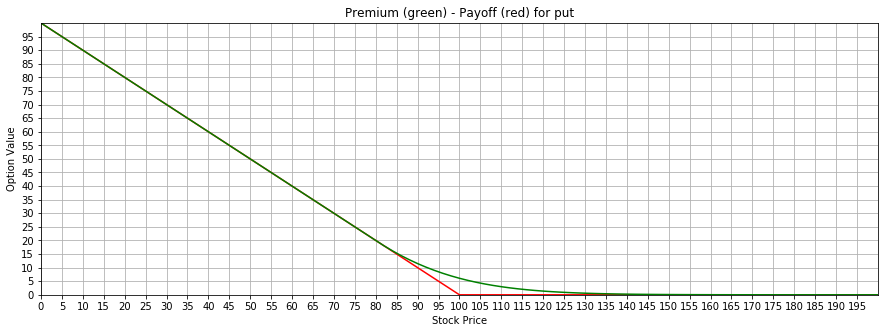

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

figure(figsize=(15,5))
grid()
plot(S,u[:,0],'r')
plot(S,u[:,N],'g')

xticks(arange(S_min,S_max,5))
yticks(arange(0,100,5))
ylim(0,100)
xlim(S_min, S_max)
xlabel('Stock Price')
ylabel('Option Value')
title('Premium (green) - Payoff (red) for ' + payout)

In [32]:
import scipy.interpolate
v = u[:,N]
f = scipy.interpolate.interp1d(S,v)

opt_european   = BlackScholes('P', S0, K, r, 0, sigma, T)
opt_binomial_e = binomial_model_european(N, S0, sigma, r, K, T)[1][0][0] 
opt_binomial_a = binomial_model_american(N, S0, sigma, r, K, T)[1][0][0]
opt_explicit   = f(S0).item(0)

print('Option price (analytic)               : ', round(opt_european,3))
print('Option price (binomial tree european) : ', round(opt_binomial_e,3))
print('Option price (binomial tree american) : ', round(opt_binomial_a,3))
print('Option price (explicit finite diff)   : ', round(opt_explicit,3))

('Option price (analytic)               : ', 10.214)
('Option price (binomial tree european) : ', 10.215)
('Option price (binomial tree american) : ', 11.493)
('Option price (explicit finite diff)   : ', 11.483)


### The log Black-Scholes Equation ###

Starting from the Black-Scholes PDE... 

\begin{equation}
\frac{\partial}{\partial t} U(S,t) +   \frac{1}{2}\sigma^2 S^2 \cdot \frac{\partial^2}{\partial S^2} U(S,t) + rS  \cdot  \frac{\partial}{\partial S} U(S,t)  -r  \cdot  U(S,t)   = 0   
\end{equation}

Let's say $Z = \ln S$, we have 

\begin{align}
&\frac{\partial U}{\partial S} = \frac{\partial U}{\partial Z}\frac{\partial Z}{\partial S} = \frac{1}{S} \frac{\partial U}{\partial Z} \notag\\
&\frac{\partial^2 U}{\partial S^2} = \frac{\partial}{\partial S} \left( \frac{1}{S} \frac{\partial U}{\partial Z} \right) = \frac{1}{S^2} \left( \frac{\partial^2 U}{\partial Z^2} - \frac{\partial U}{\partial Z} \right)
\end{align}

and we can write the $log$ BS PDE as

\begin{equation}
\frac{\partial}{\partial t} U(Z,t)  
+ \frac{1}{2}\sigma^2 \cdot \frac{\partial^2}{\partial Z^2} U(Z,t)
+ \left( r  - \frac{1}{2}\sigma^2 \right)\frac{\partial}{\partial Z} U(Z,t) 
-r  \cdot  U(Z,t)   = 0   
\end{equation}

a comparison with the general form give us:

\begin{align}
& a = \frac{1}{2} \sigma^2 \notag\\
& b = \left( r - \frac{1}{2} \sigma^2 \right) \notag\\
& c = -r \notag
\end{align}

The change of variable approach has the property that the various coefficient are now independent of $i$ and it can be shown that it is numerically most stable and efficient.


### Connection with Tree ###

Now the discrete version with a small change in the last term (can you see it?) 

\begin{equation}
\frac{U_{i,k+1}-U_{i,k}}{\Delta t} = a \frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2} + b  \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S} +
c U_{i,k+1}
\end{equation}

we can write

\begin{align} 
U_{i,k+1} \left( 1- c \Delta t\right)
&= U_{i+1,k} \left[ {a\Delta t \over \Delta S^2} + {b\Delta t \over 2\Delta S} \right] \notag\\
&+ U_{i,k} \left[1 - 2 {a\Delta t \over \Delta S^2}   \right] \notag\\
&+ U_{i-1,k} \left[{a\Delta t \over \Delta S^2} - {b\Delta t \over 2\Delta S} \right]
\end{align}

to arrive to the following form
 
\begin{equation}
U_{i,k+1} =   A  U_{i+1,k}    +  B  U_{i,k}   + C    U_{i-1,k} 
\end{equation}

with
 
\begin{align} 
& A = \frac{1}{1-c\Delta t}\left[\frac{\Delta t}{\Delta S^2} a + \frac{\Delta t}{2\Delta S} b \right] \notag\\
& B = \frac{1}{1-c\Delta t}\left[1 - \frac{2\Delta t}{\Delta S^2} a\right] \notag\\
& C = \frac{1}{1-c\Delta t}\left[\frac{\Delta t}{\Delta S^2} a - \frac{\Delta t}{2\Delta S} b\right]  \notag
\end{align}

substitution for $a, b, c$ values give us

\begin{align} 
& A = \frac{1}{1+r\Delta t}
\left[\frac{\Delta t}{2\Delta S^2} \sigma^2 S^2 + \frac{\Delta t}{2\Delta S} rS \right] =
\left[\frac{1}{2} \sigma^2 i^2 \Delta t + \frac{1}{2} r i \Delta t \right]
\notag\\
& B = \frac{1}{1+r\Delta t}
\left[1 - \frac{\Delta t}{\Delta S^2} \sigma^2 S^2\right] =
\left[1 -  \sigma^2 i^2 \Delta t\right]
\notag\\
& C = \frac{1}{1+r\Delta t}
\left[\frac{\Delta t}{2\Delta S^2} \sigma^2 S^2 - \frac{\Delta t}{2\Delta S} rS\right]  =
\left[\frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t \right]
\notag
\end{align}

Now the relation with a trinomial tree is completely evident. Note that 

$$A + B + C = 1$$

<img src="img/lesson_1/explicit_method_1.png" width="60%" height="60%">

Infact we can interpret terms as follows

- $\frac{1}{2} \sigma^2 i^2 \Delta t + \frac{1}{2} r i \Delta t$ : probability of stock price increasing from $i\Delta S$ to $(i+1)\Delta S$ in time $\Delta t$;

- $1 -  \sigma^2 i^2 \Delta t$ : probability of stock price remaining unchanged at $i\Delta S$ in time $\Delta t$;  

- $\frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t$ : probability of stock price decreasing from $i\Delta S$ to $(i+1)\Delta S$ in time $\Delta t$;


### Convergence of the Explicit Method ###

Although the explicit method is simple to implement it does not always converge. Convergence of the method depends on the size of the time step, the size of the asset step and the size of coefficients $a$, $b$ and $c$. Tipically there is a severe limitation on the size of the time step

$$
\Delta t \le \frac{\Delta S^2}{2a}
$$

if we want to improve accuracy by halving the asset step, for example, we must reduce the timestep by a factor of four. The computation time then goes up by a factor of eight. If the time step constraint is not satisfied, if it is too large, then the instability is obvious from the results. It is unlikely that you will get a false but believable result if you use the explicit method.

This can be understood very well by the analogy with the trinomial tree. Infact since all terms can be interpreted as probability, we must impose

$$ 1- \sigma^2 i^2 \Delta t \ge 0 \Rightarrow \sigma^2 i^2 \Delta t \le 1$$

from this taking into account that $S = i \Delta S$, 

$$ \Delta t \le \frac{1}{\sigma^2 S^2} \Delta S^2$$

And from the third probability 

$$ \frac{1}{2} \sigma^2 i^2 \Delta t - \frac{1}{2} r i \Delta t \ge 0 $$

we can easily find a contraint on the step size of $S$

$$ \Delta S \le \frac{\sigma^2 S}{r} $$

### Conclusion ###

The advantages of the explicit method are the following:

- it is very easy to program and hard to make mistakes;
- when it does go unstable it is usually obviuos;
- it is easy to incorporate early exercise feature;

on the other hand there is a serious disadvantage due to the restrictions on the timestep so the method can be slower than other schemes. 


## Implicit Methods ##


### The Fully Implicit Method ###

The **fully implicit method** uses the points as shown in Figure (...) to calculate the option value. The scheme is superficially just like the explicit scheme but now the delta and gamma (first and second derivative with respect to $S$) are calculated at time step $k+1$ instead of $k$

\begin{equation}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t} + 
a_i \left( \frac{U_{i+1,k+1}- 2 U_{i,k+1}+U_{i-1,k+1}}{\Delta S^2} \right) + 
b_i \left( \frac{U_{i+1,k+1}-U_{i-1,k+1}}{2\Delta S} \right) +
c_i U_{i,k+1} = 0
\end{equation}

this can be written as 

\begin{equation}
U_{i,k} =   A_i  U_{i+1,k+1}    +  B_i  U_{i,k+1}   + C_i    U_{i-1,k+1} 
\end{equation}
 
with
 
\begin{align} 
& A_i = -\nu_1 a_i + \frac{1}{2}\nu_2 b_i \\
& B_i = 1 + 2 \nu_1 a_i - \Delta t \> c_i \\
& C_i = -\nu_1 a_i - \frac{1}{2}\nu_2 b_i
\end{align}

where as above

$$ \nu_1 = \frac{\Delta t}{\Delta S^2}, \quad \quad \nu_2 = \frac{\Delta t}{\Delta S}$$
 
Also in this case this equation doesn't hold for $i=0$ or $i=I$ and the boundary conditions supply the two remaining equations. 

These scheme is very different from the explicit scheme, first of all it's possible to demonstrate that the method doesn't suffer anymore from the restriction on the time step. The asset step can be small and the time step large without the method running into stability problem. The second difference concern the solution procedure, infact the solution of the difference equation is no longer so straightforward. To get $U_{i,k+1}$ from $U_{i,k}$ we have to solve a set of linear equations, each $U_{i,k+1}$ is directly linked to its two neighbours and thus indirectly linked to every option value at the same time step.  

\begin{equation}
\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  
\end{array}  
\right]
=
\left[\begin{array}{c} U_{0,k} \\ U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}\\ U_{I,k}  \end{array} \right] 
\end{equation}

The matrix have $I-1$ rows and $I+1$ columns so this is a representation of $I-1$ equations in $I+1$ unknowns. The two equations that we are missing come from the boundary conditions. We can rewrite the previous equation taking explicitly into account the boundary conditions as:

\begin{equation}
\begin{bmatrix} 
   &  1+B_1 &  C_1    &  0      &  \cdots  
\\ &  A_2   &  1+B_2  &  C_2    &  \cdots  
\\ &  0     &  A_3    &  1+B_3  &  \cdots  
\\ & \ddots &  \ddots &  \ddots &  \vdots 
\\ & \cdots &  \cdots & A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c}  U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}   
\end{array}  
\right]
+
\left[
\begin{array}{c}  A_1U_{0,k+1} - U_{0,k} \\ 0  \\ \vdots \\ C_I U_{I,k+1} -U_{I,k}   
\end{array}  
\right]
=
\left[\begin{array}{c} U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}  \end{array} \right] 
\end{equation}

or

\begin{equation}
\begin{bmatrix} 
   &  1+B_1 &  C_1    &  0      &  \cdots  
\\ &  A_2   &  1+B_2  &  C_2    &  \cdots  
\\ &  0     &  A_3    &  1+B_3  &  \cdots  
\\ & \ddots &  \ddots &  \ddots &  \vdots 
\\ & \cdots &  \cdots & A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[ 
\begin{array}{c}  U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}   
\end{array}  
\right]
=
\left[\begin{array}{c} U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}  \end{array} \right] 
-
\left[
\begin{array}{c}  A_1U_{0,k+1} - U_{0,k} \\ 0  \\ \vdots \\ C_I U_{I,k+1} -U_{I,k}   
\end{array}  
\right]
=
\left[
\begin{array}{c}  q_{1,k} \\ q_{2, k}  \\ \vdots \\ q_{I-1,k}   
\end{array}  
\right]
\end{equation}

$$
\mathbf{M_{imp}}\mathbf{U}=\mathbf{q}
$$

This matrix equation holds whichever of the boundary conditions we have. Solution methods are various but two of the most used are **LU Decomposition** and **Successive Over Relaxation**. The LU decomposition is an example of a 'direct method'. This means that it finds the exact solution of the equations in one go through matrix operations.  An alternative strategy is to employ an *iterative method*. Iterative methods differ from direct methods in that one starts with a guess for the solution and successively improves it until it converges near enough to the exact solution. In a direct method one obtains the solution without any interaction. An advantage of iterative methods over direct methods is that they generalise in straightforward ways to American option problems whereas direct methods do not. For this reason in the following we shall concentrate only on a particular kind of iterative method: the SOR (successive over-relaxation).

#### Successive Over-Relaxation Method (SOR) ####

This is an example of an 'indirect method', with this we solve the equations iteratively. We'll give a description of this method from a very generic point of view.

Suppose that the **square** matrix $\mathbf{M}$ in the matrix equation

$$
\mathbf{M}\mathbf{v}=\mathbf{q}
$$

has entries $M_{ij}$ then the system of equations can be written as

\begin{align}
&M_{11}v_1 + M_{12}v_2 + \dots + M_{1N}v_N = q_1 \notag\\
&M_{21}v_1 + M_{22}v_2 + \dots + M_{2N}v_N = q_2 \notag\\
&\dots \dots\notag\\
&M_{N1}v_1 + M_{N2}v_2 + \dots + M_{NN}v_N = q_N \\
\end{align}

$N$ is the number of equations. Rewrite this as

\begin{align}
&M_{11}v_1 = q_1 - (M_{12}v_2 + \dots + M_{1N}v_N )\notag\\
&M_{22}v_2 = q_2 - (M_{21}v_1 + \dots + M_{2N}v_N ) \notag\\
&\dots \dots\notag\\
&M_{NN}v_N = q_N - ( M_{N1}v_1 + \dots)\\
\end{align}

The system is easily *iteratively* using

\begin{align}
&v_1^{n+1} = \frac{1}{M_{11}} \left( q_1 - (M_{12}v_2^n + \dots + M_{1N}v_N^n )\right) \notag\\
&v_2^{n+1} = \frac{1}{M_{22}} \left( q_2 - (M_{21}v_1^n + \dots + M_{2N}v_N^n )\right) \notag\\
&\dots \dots\notag\\
&v_N^{n+1} = \frac{1}{M_{NN}} \left( q_N - ( M_{N1}v_1^n + \dots)\right)\\
\end{align}

where the superscript $n$ denotes the level of the iteration **and not the timestep**. This iteration is started from some initial guess $\mathbf{v}^0$. In our case it is usual to start with the value of the option at the previous timestep as the initial guess for the next timestep. This iterative method is called the **Jacobi Method**.

The matrix $\mathbf{M}$ can be written as the sum of a diagonal matrix $\mathbf{D}$, an upper triangular matrix $\mathbf{U}$ with zeros on the diagonal and a lower triangular matrix $\mathbf{L}$ also with zeros on the diagonal:

$$\mathbf{M} = \mathbf{D} + \mathbf{U} + \mathbf{L}$$

Using this representation we can write the Jacobi method in a different but elegant way

\begin{equation}
\mathbf{v}^{n+1} = \mathbf{D}^{-1} \left( \mathbf{q} - \mathbf{U}\cdot \mathbf{v}^n - \mathbf{L}\cdot \mathbf{v}^n \right)
\end{equation}

The idea of the *successive over-relaxation method* is to speed up convergence of the procedure using the right hand side of the previous equation as a correction factor of the value of $\mathbf{v}$ estimated at the previous step

\begin{equation}
\mathbf{v}^{n+1} = \mathbf{v}^{n+1} + \omega \mathbf{D}^{-1} \left( \mathbf{q} - \mathbf{U}\cdot \mathbf{v}^n - \mathbf{L}\cdot \mathbf{v}^n \right)
\end{equation}

$\omega$ is the so called *over-relaxation* parameter and its value must lie between 1 and 2. Usually this parameter is estimated by experiment making some test for the optimal value. 


### Python Implementation of Fully Implicit Method ###

In [33]:
payout = 'put'   # option type 

In [34]:
import sys
#
# Parameters to define the range in space and time
#
S_min  =   0.0;
S_max  = 150.0;
L      = S_max - S_min;

N      = 1002;                # Number of time steps
k      = float(T)/float(N);   # time step size
I      = 100;                  # Number of space steps
h      = float(L)/float(I);   # space step size

S      = np.zeros((I+1))
A      = np.zeros((I+1))
B      = np.zeros((I+1))
C      = np.zeros((I+1))
Payoff = np.zeros((I+1))
UOld   = np.zeros((I+1))
UNew   = np.zeros((I+1))
#
# Relaxation parameters
#
omega = 1.5
error = 1e6
#
# Precision parameters
#
EPS     = 0.00001
MAXITER = 100
#
# Initial Conditions
#
for i in range(0, I+1):
    S[i] = i * h
    if payout == 'call':
        UOld[i] = np.maximum(S[i] - K,0)
    else:
        UOld[i] = np.maximum(K - S[i],0)    
Payoff = UOld


The implicit method matrix coefficients are

\begin{align} 
& A_i = -\nu_1 a_i + \frac{1}{2}\nu_2 b_i \notag\\
& B_i = 1 + 2 \nu_1 a_i - \Delta t \> c_i \notag\\
& C_ = -\nu_1 a_i - \frac{1}{2}\nu_2 b_i  \notag
\end{align}

so due to discretization process they transform into

\begin{align}
&A_i = -\frac{1}{2} i \> k \left( \sigma^2 i - r \right) \notag\\
&B_i = 1 + k \left( \sigma^2 i^2 +r \right) \notag\\
&C_i = - \frac{1}{2} k \> i \left( \sigma^2 i + r \right) \cdot k \notag
\end{align}

In [35]:
#
# Matrix elements
#
for i in range(1,I):
    A[i] = -k * 0.5 * i * (sigma * sigma * i - r)
    B[i] = 1 + 1.0 * k * (sigma * sigma * i * i + r)
    C[i] = -k * 0.5 * i * (sigma * sigma * i + r)

Note that in our parametrization, $A$ is the subdiagonal matrix, $C$ is the superdiagonal matrix and $B$ is the diagonal one.

In [36]:
#
# Cycle on time
#
for n in range(1, N-1):
    sys.stdout.write("\r" + "Now running time step nr: " + str(n) + "/" + str(N-2))
    sys.stdout.flush()
    t = n * k
    #
    # initially UNew is set equal to UOld
    #
    UNew[1:I-1] = UOld[1:I-1]
    m = 0
    #
    # Boundary Conditions
    #
    if payout == 'call':
        UNew[0] = 0
        UNew[I] = h * I * math.exp(-delta * t) - K * math.exp(-r * t)
    else:
        UNew[0] = K * math.exp(-r * t)
        UNew[I] = 0

    while (error > EPS) and (m < MAXITER): 
        error = 0
        for i in range(1,I):
            y       = (UOld[i] - A[i] * UNew[i - 1] - C[i] * UNew[i + 1] ) / B[i]
            diff    = y - UNew[i]
            error   = error + diff * diff
            UNew[i] = UNew[i] + omega * diff
            #
            # this is were we introduce the early exercise 
            #
            UNew[i] = max(UNew[i], Payoff[i])
        m = m + 1
    #
    UOld[1:I-1] = UNew[1:I-1]

f = scipy.interpolate.interp1d(S,UNew)
opt_implicit = f(S0).item(0)

print('\r')
print('Option price (implicit finite diff)   : ', round(opt_implicit,3))

Now running time step nr: 1000/1000
('Option price (implicit finite diff)   : ', 11.485)


### The Crank-Nicolson Method ###

The Fully Implicit Method can be significantly improved with a relatively limited computational effort.

This method can be thought of as an average of the explicit method and the fully implicit method. It uses the six points shown in Figure (...).

The Crank-Nicolson scheme is 

\begin{align}
\frac{U_{i,k} - U_{i,k+1}}{\Delta t}  
&+ \frac{a_i}{2}\left( \frac{U_{i+1,k+1}- 2 U_{i,k+1}+U_{i-1,k+1}}{\Delta S^2} \right)
 + \frac{a_i}{2}\left(\frac{U_{i+1,k}- 2 U_{i,k}+U_{i-1,k}}{\Delta S^2}\right)\notag\\
&+ \frac{b_i}{2}\left( \frac{U_{i+1,k+1}-U_{i-1,k+1}}{2\Delta S} \right)
 + \frac{b_i}{2}\left( \frac{U_{i+1,k}-U_{i-1,k}}{2\Delta S}  \right)\notag\\
&+ \frac{1}{2}c_i U_{i,k}
 + \frac{1}{2}c_i U_{i,k+1}
= 0
\end{align}

This can be written as

\begin{equation}
-A_i  U_{i-1,k+1} + (1 - B_i) U_{i,k+1} - C_i U_{i+1,k+1} =
 A_i  U_{i-1,k} + (1 + B_i) U_{i,k} + C_i U_{i+1,k}
\end{equation}

where

\begin{align} 
& A = \frac{1}{2}\nu_1 a_i + \frac{1}{4}\nu_2 b_i \\
& B = - \nu_1 a_i + \frac{1}{2} \Delta t \> c_i \\
& C = \frac{1}{2}\nu_1 a_i - \frac{1}{4}\nu_2 b_i
\end{align}

These equations only hold for $1 \le i \le I-1$. The boundary contitions again supply the two missing equations but in this case they are harder to deal with than in the explicit methods. We shall return on this subject in a while.

\begin{equation}
\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  \end{array} \right] 
=
\begin{bmatrix} 
-A_1 &  1-B_1 &  -C_1 &  0 &  \cdots &  0 
\\ 0 &  -A_2 &  1-B_2  &  -C_2 &  \cdots &  0 
\\ 0 &  0 &  -A_3 &  1-B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   -A_{I-1} &  1-B_{I-1} & - C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k} \\ U_{1,k} \\ U_{2,k}  \\ \vdots \\ U_{I-1,k}\\ U_{I,k}  \end{array} \right] 
\end{equation}

The two matrices have $I-1$ rows and $I+1$ columns so this is a representation of $I-1$ equations in $I+1$ unknowns. The two equations that we are missing come from the boundary conditions.



#### Boundary Conditions ####

**$U_{0,k+1}$ and/or $U_{I,k+1}$ given**

We can write

\begin{equation}
\begin{bmatrix} 
A_1 &  1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ 0 &  A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} &  C_{I-1}
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{0,k+1} \\ U_{1,k+1} \\ U_{2,k+1}  \\ \vdots \\ U_{I-1,k+1}\\ U_{I,k+1}  \end{array} \right] 
\end{equation}

as 

\begin{equation}
\begin{bmatrix} 
1+B_1 &  C_1 &  0 &  \cdots &  0 
\\ A_2 &  1+B_2  &  C_2 &  \cdots &  0 
\\ 0 &  A_3 &  1+B_3  &  \cdots &  0 
\\ \vdots &  &  \ddots &  \ddots &  \vdots 
\\ 0 &  \cdots &  &   A_{I-1} &  1+B_{I-1} 
\end{bmatrix} \cdot 
\left[\begin{array}{c} U_{1,k+1} \\ U_{2,k+1} \\ U_{3,k+1}  \\ \vdots \\ U_{I-1,k+1}  \end{array} \right] 
+
\left[\begin{array}{c} A_1U_{0,k+1} \\ 0 \\ 0  \\ \vdots \\ C_{I-1}U_{I,k+1}  \end{array} \right] 
= \mathbf{M}_L^{k+1} \mathbf{U}_{k+1} + \mathbf{r}_k
\end{equation}

We can do the same for the right hand side of the equation, so we finally get

\begin{equation}
\mathbf{M}_L^{k+1} \mathbf{U}_{k+1} + \mathbf{r}_k = \mathbf{M}_R^{k} \mathbf{U}_{k}
\end{equation}

The solution of this matrix equation can be implemented using the SOR method we discussed previously.

### Python Implementation of Crank-Nicolson Method ###

To be done as an exercise.

# References #

*Paul Wilmott*, **Derivatives, The Theory and Practice of Financial Engineering**, University Edition

*Paul Wilmott, Sam Howison and Jeff Dewinne*, **The Mathematics of Financial Derivatives, A Student Introduction**, Cambridge University Press

*John C. Hull*, **Option, Futures and Other Derivatives**, 6th Edition, Prentice Hall


# Appendix - Function Code #

In [ ]:
S0    =  90.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.05  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

In [4]:
def finite_difference_explicit(payout, S0, K, sigma, T, american = True, N = 1000, I = 100):
    #
    # Parameters to define the range in space and time
    #
    S_min = 0.0;
    S_max = 200.0;
    L     = S_max - S_min;

    #N     = 1000;               # Number of time steps
    #I     = 100;                # Number of space steps
    k     = float(T)/float(N);  # time step size
    h     = float(L)/float(I);  # space step size

    sig   = sigma
    sig2  = sig*sig

    S     = np.zeros((I+1))
    u     = np.zeros((I+1,N+1))

    if payout == 'call':
        for i in range(0,I+1):
            S[i]   = i*h;
            u[i,0] = max(S[i]-K,0);
        #
        # We suppose that the range of S is sufficiently large, therefore impose the 
        # boundary conditions for all times:
        #
        # Value at the boundary 
        for n in range (0, N + 1):
            # If the underlying is zero even the option value is zero
            u[0,n] = 0.0;
            # for large values of the underlying value of the option tends asymptotically
            # to S - K * exp(-rt)
            u[I,n] = S[I] - K * math.exp(-r*k*n);

    if payout == 'put':
        for i in range(0,I+1):
            S[i] = S_min + i*h;
            u[i,0] = max(K - S[i],0);
        #
        # Value at the boundary 
        #
        for n in range (0, N + 1):
            u[0,n] = K * math.exp(-r*k*n);
            u[I,n] = 0.0;
    #
    # Implementation of the explicit method
    #
    for n in range(0,N): # time loop
        for i in range (0,I): # space loop
            A = 0.5 * (sig2 * i * i + r * i ) * k
            B = 1.0 - (sig2 * i * i + r) * k 
            C = 0.5 * (sig2 * i * i - r * i) * k
            u[i,n+1] = A * u[i+1,n] + B * u[i,n] + C * u[i-1,n];
            #
            # early exercise condition
            #
            if payout == 'put':
                exercise = np.maximum(K-S[i],0)
            else:
                exercise = np.maximum(S[i]-K,0)
            if american:    
                u[i, n+1] = np.maximum(exercise, u[i, n+1]) 
    
    f = scipy.interpolate.interp1d(S,u[:,N])
    return f(S0).item(0)               

In [ ]:
def finite_difference_implicit(payout, S0, K, sigma, T, american = True):
    import sys
    #
    # Parameters to define the range in space and time
    #
    S_min  =   0.0;
    S_max  = 150.0;
    L      = S_max - S_min;

    N      = 1002;                # Number of time steps
    k      = float(T)/float(N);   # time step size
    I      = 250;                  # Number of space steps
    h      = float(L)/float(I);   # space step size

    S      = np.zeros((I+1))
    A      = np.zeros((I+1))
    B      = np.zeros((I+1))
    C      = np.zeros((I+1))
    Payoff = np.zeros((I+1))
    UOld   = np.zeros((I+1))
    UNew   = np.zeros((I+1))
    #
    # Relaxation parameters
    #
    omega = 1.5
    error = 1e6
    #
    # Precision parameters
    #
    EPS     = 0.00001
    MAXITER = 100
    #
    # Initial Conditions
    #
    for i in range(0, I+1):
        S[i] = i * h
        if payout == 'call':
            UOld[i] = np.maximum(S[i] - K,0)
        else:
            UOld[i] = np.maximum(K - S[i],0)    
    Payoff = UOld
    #
    # Matrix elements
    #
    for i in range(1,I):
        A[i] = -k * 0.5 * i * (sigma * sigma * i - r)
        B[i] = 1 + 1.0 * k * (sigma * sigma * i * i + r)
        C[i] = -k * 0.5 * i * (sigma * sigma * i + r)
    #
    # Cycle on time
    #
    for n in range(1, N-1):
        sys.stdout.write("\r" + "Now running time step nr: " + str(n) + "/" + str(N-2))
        sys.stdout.flush()
        t = n * k
        #
        # initially UNew is set equal to UOld
        #
        UNew[1:I-1] = UOld[1:I-1]
        m = 0
        #
        # Boundary Conditions
        #
        if payout == 'call':
            UNew[0] = 0
            UNew[I] = h * I * math.exp(-delta * t) - K * math.exp(-r * t)
        else:
            UNew[0] = K * math.exp(-r * t)
            UNew[I] = 0

        while (error > EPS) and (m < MAXITER): 
            error = 0
            for i in range(1,I):
                y       = (UOld[i] - A[i] * UNew[i - 1] - C[i] * UNew[i + 1] ) / B[i]
                diff    = y - UNew[i]
                error   = error + diff * diff
                UNew[i] = UNew[i] + omega * diff
                #
                # this is were we introduce the early exercise opportunity
                #
                if american:
                    UNew[i] = max(UNew[i], Payoff[i])
            m = m + 1
        #
        UOld[1:I-1] = UNew[1:I-1]

    print('\r')
    f = scipy.interpolate.interp1d(S,UNew)
    return f(S0).item(0)

In [ ]:
opt_european   = BlackScholes('P', S0, K, r, 0, sigma, T)
opt_binomial_e = binomial_model_european(N, S0, sigma, r, K, T, 'put')[1][0][0] 
opt_binomial_a = binomial_model_american(N, S0, sigma, r, K, T, 'put')[1][0][0]
opt_explicit   = finite_difference_explicit('put', S0, K, sigma, T, True)
opt_implicit   = finite_difference_implicit('put', S0, K, sigma, T, True)

print('Option price (analytic)               : ', round(opt_european,3))
print('Option price (binomial tree european) : ', round(opt_binomial_e,3))
print('Option price (binomial tree american) : ', round(opt_binomial_a,3))
print('Option price (explicit finite diff)   : ', round(opt_explicit,3))
print('Option price (implicit finite diff)   : ', round(opt_implicit,3))        

## On the Stability of Explicit Method##

In [ ]:
nn     = range(1,1000)
prices = [finite_difference_explicit('put', S0, K, sigma, T, True, n, 50) for n in nn]
exact  = finite_difference_explicit('put', S0, K, sigma, T, True)

In [ ]:
%matplotlib inline

ref = np.array([exact for n in nn])

fig = pl.figure(figsize=[10, 5])
pl.plot(nn, prices, color = 'r')
pl.plot(nn, ref,'b--',color = 'g')
#pl.ylim(0,10000)
pl.xlim(0,100)
pl.grid()
pl.show()